<a href="https://colab.research.google.com/github/sriksmachi/sriksml/blob/main/language-models/llm_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine tuning FLAN T5

This notebook contains code artifacts for fine tuning Flan-T5-small model. The notebook does the following tasks.

1. Use a pre-trained google/flan-t5-small as the model.
2. Verify if the summarization task works.
3. Verify if the Q&A task works.
4. Verify if English to French translation task works.
5. Programmatically print the names of all the model layers and their dimensions.
6. Programmatically print the total number of parameters/weights in this model.
7. Set the tensor in final layer (decoder.final_layer_norm.weight) to all zeros.
8. Verify if the Q&A task works aWer reseXng the weights of the above layer.
9. Replace the decoder.final_layer_norm.weight with a layer of smaller dimensions and adjust all the dependent layers to match the dimension
10. Reload the original google/flan-t5-small model.
11. Train the model for a Q&A task that takes a context as additional input along with the queson. You can use SQuAD dataset. Choose an
appropriate task prefix/trigger word and justify the choice.
12. Evaluate the quality of the model

Paper: https://arxiv.org/abs/2210.11416 </br>
Official repo: https://github.com/google-research/t5x

In [236]:
%%bash
pip install -q transformers[torch]
pip install -q sentencepiece
pip install -q datasets
pip install -q tokenizers
pip install -q evaluate
pip install -q rouge_score
pip install -q nltk

## Import Libraries

In [237]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments
from transformers import Trainer
import pandas as pd
import warnings
import torch
from torch import nn
import nltk
import evaluate
import numpy as np
from transformers import T5Tokenizer, DataCollatorForSeq2Seq
from transformers import T5ForConditionalGeneration, Seq2SeqTrainingArguments, Seq2SeqTrainer
from datasets import load_dataset

warnings.filterwarnings('ignore')


In [238]:
from transformers.models.blip_2.modeling_blip_2 import AutoModelForSeq2SeqLM
model_name = "google/flan-t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

## Metrics

In [239]:
import nltk
import evaluate
nltk.download('punkt', quiet=True)

# loading Rouge
rogue_metric = evaluate.load('rouge')

## Text Summarization

In [240]:
huggingface_dataset_name = "knkarthick/dialogsum"
dataset = load_dataset(huggingface_dataset_name)
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 12460
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 500
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 1500
    })
})

In [241]:
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
sentence = "How does summarization work ?"
sentence_encoded = tokenizer(sentence, return_tensors='pt')
print(sentence_encoded)
sentence_decoded = tokenizer.decode(sentence_encoded["input_ids"][0])
print(sentence_decoded)

{'input_ids': tensor([[ 571,  405, 4505, 1635, 1707,  161,    3,   58,    1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]])}
How does summarization work?</s>


In [242]:
import random
random_idx = random.randint(0, len(dataset["train"]))
print("Dialogue")
sentence = dataset["train"][random_idx]["dialogue"]
print(sentence)
print("====="*10)
print("Baseline Summary")
baseline_summary = dataset["train"][random_idx]["summary"]
print(baseline_summary)
print("====="*10)
sentence_encoded = tokenizer(sentence, return_tensors='pt')
pred_summary = model.generate(sentence_encoded['input_ids'], max_new_tokens=50)
sentence_decoded = tokenizer.decode(pred_summary[0], skip_special_tokens=True)
print("Generated Summary without prompt")
print(sentence_decoded)
print("====="*10)
rouge_score = rogue_metric.compute(predictions=[sentence_decoded], references=[baseline_summary])
print(rouge_score)

Dialogue
#Person1#: What an amazing film! I can't remember the last time I felt this good coming out of a movie theater!
#Person2#: I know what you mean. Robert Redford is my favorite actor, so I knew I would like it.
#Person1#: Yeah, but there were so many little things that were cool - the music, the lighting, the way the camera kept moving around... I don't think I've ever seen a more interesting film.
#Person2#: It definitely got me thinking. Also, there was one pan in the middle that was pretty sad...
#Person1#: Oh, don't remind me! I cried that whole time!
#Person2#: Come on. Let's get some coffee and pie and keep talking!
#Person1#: Great idea!
Baseline Summary
#Person1# and #Person2# discuss a movie they just finished. Both of them think it's amazing and interesting.
Generated Summary without prompt
I'm so glad I did!
{'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0, 'rougeLsum': 0.0}


In [246]:
prompt = f"You are a sentence summarization bot. Please summarize the conversation.Dialogue:\n{sentence}.\n"
print(prompt)
sentence_encoded = tokenizer(prompt, return_tensors='pt')
pred_summary = model.generate(sentence_encoded['input_ids'],max_new_tokens=50)
sentence_decoded = tokenizer.decode(pred_summary[0], skip_special_tokens=True)
print("Generated Summary with prompt")
print(sentence_decoded)
rouge_score = rogue_metric.compute(predictions=[sentence_decoded], references=[baseline_summary])
print(rouge_score)

You are a sentence summarization bot. Please summarize the conversation.Dialogue:
#Person1#: What an amazing film! I can't remember the last time I felt this good coming out of a movie theater!
#Person2#: I know what you mean. Robert Redford is my favorite actor, so I knew I would like it.
#Person1#: Yeah, but there were so many little things that were cool - the music, the lighting, the way the camera kept moving around... I don't think I've ever seen a more interesting film.
#Person2#: It definitely got me thinking. Also, there was one pan in the middle that was pretty sad...
#Person1#: Oh, don't remind me! I cried that whole time!
#Person2#: Come on. Let's get some coffee and pie and keep talking!
#Person1#: Great idea!.

Generated Summary with prompt
I'm so glad I did!
{'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0, 'rougeLsum': 0.0}


## Q & A Task

In [247]:
squad = load_dataset("squad", split="train[:5000]")
squad = squad.train_test_split(test_size=0.2)
squad

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 4000
    })
    test: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 1000
    })
})

In [248]:
squad["train"][0]

{'id': '56cfee5d234ae51400d9c0f7',
 'title': 'Frédéric_Chopin',
 'context': 'Chopin also endowed popular dance forms with a greater range of melody and expression. Chopin\'s mazurkas, while originating in the traditional Polish dance (the mazurek), differed from the traditional variety in that they were written for the concert hall rather than the dance hall; "it was Chopin who put the mazurka on the European musical map." The series of seven polonaises published in his lifetime (another nine were published posthumously), beginning with the Op. 26 pair (published 1836), set a new standard for music in the form. His waltzes were also written specifically for the salon recital rather than the ballroom and are frequently at rather faster tempos than their dance-floor equivalents.',
 'question': 'How many polonaises were published while Chopin lived?',
 'answers': {'text': ['seven'], 'answer_start': [363]}}

In [249]:
random_idx = random.randint(0, len(squad["train"]))
question = squad["train"][random_idx]["question"]
context = squad["train"][random_idx]["context"]
title = squad["train"][random_idx]["title"]
baseline_answer = squad["train"][random_idx]["answers"]
print("Context:")
print(context)
print("====="*10)
prompt = f"Please answer a question about the following article about {title}:\n\n{context}\n\n{question}"
print(prompt + question)
print("====="*10)
print("Baseline answer:")
print(baseline_answer['text'])
print("====="*10)
sentence_encoded = tokenizer(prompt + question, return_tensors='pt', max_length=256, truncation=True)
pred_answer = model.generate(sentence_encoded['input_ids'], max_new_tokens=100)
print(pred_answer)
sentence_decoded = tokenizer.decode(pred_answer[0], skip_special_tokens=True)
print("Generated Answer")
print(sentence_decoded)
print("====="*10)
rouge_score = rogue_metric.compute(predictions=[sentence_decoded], references=[baseline_answer['text']])
print(rouge_score)

Context:
In 1827, soon after the death of Chopin's youngest sister Emilia, the family moved from the Warsaw University building, adjacent to the Kazimierz Palace, to lodgings just across the street from the university, in the south annex of the Krasiński Palace on Krakowskie Przedmieście,[n 5] where Chopin lived until he left Warsaw in 1830.[n 6] Here his parents continued running their boarding house for male students; the Chopin Family Parlour (Salonik Chopinów) became a museum in the 20th century. In 1829 the artist Ambroży Mieroszewski executed a set of portraits of Chopin family members, including the first known portrait of the composer.[n 7]
Please answer a question about the following article about Frédéric_Chopin:

In 1827, soon after the death of Chopin's youngest sister Emilia, the family moved from the Warsaw University building, adjacent to the Kazimierz Palace, to lodgings just across the street from the university, in the south annex of the Krasiński Palace on Krakowskie

## Language Translation

In [134]:
prompt = "Translate the following sentence to french \n It is a wonderful day"
inputs = tokenizer(prompt, return_tensors='pt')
print(prompt)
translated = model.generate(inputs["input_ids"], max_new_tokens=50)
pred = tokenizer.decode(translated[0], skip_special_tokens=True)
print(f"Predicted sentence: {pred}")
rogue_metric.compute(predictions=[pred], references=["C'est une journée merveilleuse"])

Translate the following sentence to french 
 It is a wonderful day
Predicted sentence: Il est un jour merveilleuse


{'rouge1': 0.3636363636363636,
 'rouge2': 0.0,
 'rougeL': 0.3636363636363636,
 'rougeLsum': 0.3636363636363636}

## Describe the model

In [135]:
# print(model)

In [136]:
def format_number_to_millions(number):
  return f'{number / 1_000_000:.2f}M'

def print_parameters_summary(model):
  total_params = 0
  trainable_params = 0
  params = model.named_parameters()
  for name, param in params:
      if param.requires_grad:
          trainable_params += param.numel()
      total_params += param.numel()
  return total_params, trainable_params

total_params, trainable_params = print_parameters_summary(model)
print(f'Total params: {format_number_to_millions(total_params)}')
print(f'Trainable params: {format_number_to_millions(total_params)}')

Total params: 76.96M
Trainable params: 76.96M


In [137]:
dict = {}
for name, param in model.named_parameters():
  dict[name] = param.shape
df = pd.DataFrame.from_dict(dict, orient='index')
df

,0,1
shared.weight,32128,512.0
encoder.block.0.layer.0.SelfAttention.q.weight,384,512.0
encoder.block.0.layer.0.SelfAttention.k.weight,384,512.0
encoder.block.0.layer.0.SelfAttention.v.weight,384,512.0
encoder.block.0.layer.0.SelfAttention.o.weight,512,384.0
...,...,...
decoder.block.7.layer.2.DenseReluDense.wi_1.weight,1024,512.0
decoder.block.7.layer.2.DenseReluDense.wo.weight,512,1024.0
decoder.block.7.layer.2.layer_norm.weight,512,NaN
decoder.final_layer_norm.weight,512,NaN


## Setting normalization weights to Zero

In [138]:
model.decoder.final_layer_norm.weight = nn.Parameter(torch.zeros(512))
model.decoder.final_layer_norm.weight[:5]

tensor([0., 0., 0., 0., 0.], grad_fn=<SliceBackward0>)

In [139]:
random_idx = random.randint(0, len(squad["train"]))
question = squad["train"][random_idx]["question"]
context = squad["train"][random_idx]["context"]
baseline_answer = squad["train"][random_idx]["answers"]
print("Context:")
print(context)
print("====="*10)
prompt = f"given the context, answer the question in few sentences .\n context\n {context} Question\n {question}"
print(prompt + question)
print("====="*10)
print("Baseline answer:")
print(baseline_answer)
print("====="*10)
sentence_encoded = tokenizer(prompt + question, return_tensors='pt', max_length=256, truncation=True)
pred_answer = model.generate(sentence_encoded['input_ids'], max_new_tokens=20)
sentence_decoded = tokenizer.decode(pred_answer[0], skip_special_tokens=False)
print("Generated Answer")
print(sentence_decoded)
print("====="*10)
rouge_score = rogue_metric.compute(predictions=[sentence_decoded], references=[baseline_answer['text']])
print(rouge_score)

Context:
The earthquake had a magnitude of 8.0 Ms and 7.9 Mw. The epicenter was in Wenchuan County, Ngawa Tibetan and Qiang Autonomous Prefecture, 80 km west/northwest of the provincial capital of Chengdu, with its main tremor occurring at 14:28:01.42 China Standard Time (06:28:01.42 UTC), on May 12, 2008 lasting for around 2 minutes, in the quake almost 80% of buildings were destroyed.
given the context, answer the question in few sentences .
 context
 The earthquake had a magnitude of 8.0 Ms and 7.9 Mw. The epicenter was in Wenchuan County, Ngawa Tibetan and Qiang Autonomous Prefecture, 80 km west/northwest of the provincial capital of Chengdu, with its main tremor occurring at 14:28:01.42 China Standard Time (06:28:01.42 UTC), on May 12, 2008 lasting for around 2 minutes, in the quake almost 80% of buildings were destroyed. Question
 How long did the main tremor last?How long did the main tremor last?
Baseline answer:
{'text': ['2 minutes'], 'answer_start': [317]}
Generated Answer
<

## Change layer dimensions

In [140]:
# model.decoder.final_layer_norm.weight = nn.Parameter(torch.zeros(256))
# model.lm_head.weight = nn.Parameter(torch.zeros(32128, 256))
# for param in model.decoder.final_layer_norm.parameters():
#   param.requires_grad = True

In [141]:
model_name = "google/flan-t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name, d_model=256, ignore_mismatched_sizes=True)
dict = {}
for name, param in model.named_parameters():
  dict[name] = param.shape
df = pd.DataFrame.from_dict(dict, orient='index')
df

Some weights of T5ForConditionalGeneration were not initialized from the model checkpoint at google/flan-t5-small and are newly initialized because the shapes did not match:
- decoder.block.0.layer.0.SelfAttention.k.weight: found shape torch.Size([384, 512]) in the checkpoint and torch.Size([384, 256]) in the model instantiated
- decoder.block.0.layer.0.SelfAttention.o.weight: found shape torch.Size([512, 384]) in the checkpoint and torch.Size([256, 384]) in the model instantiated
- decoder.block.0.layer.0.SelfAttention.q.weight: found shape torch.Size([384, 512]) in the checkpoint and torch.Size([384, 256]) in the model instantiated
- decoder.block.0.layer.0.SelfAttention.v.weight: found shape torch.Size([384, 512]) in the checkpoint and torch.Size([384, 256]) in the model instantiated
- decoder.block.0.layer.0.layer_norm.weight: found shape torch.Size([512]) in the checkpoint and torch.Size([256]) in the model instantiated
- decoder.block.0.layer.1.EncDecAttention.k.weight: found sha

,0,1
shared.weight,32128,256.0
encoder.block.0.layer.0.SelfAttention.q.weight,384,256.0
encoder.block.0.layer.0.SelfAttention.k.weight,384,256.0
encoder.block.0.layer.0.SelfAttention.v.weight,384,256.0
encoder.block.0.layer.0.SelfAttention.o.weight,256,384.0
...,...,...
decoder.block.7.layer.2.DenseReluDense.wi_1.weight,1024,256.0
decoder.block.7.layer.2.DenseReluDense.wo.weight,256,1024.0
decoder.block.7.layer.2.layer_norm.weight,256,NaN
decoder.final_layer_norm.weight,256,NaN


In [142]:
random_idx = random.randint(0, len(squad["train"]))
question = squad["train"][random_idx]["question"]
context = squad["train"][random_idx]["context"]
baseline_answer = squad["train"][random_idx]["answers"]
print("Context:")
print(context)
print("====="*10)
prompt = f"given the context, answer the question in few sentences .\n context\n {context} Question\n {question}"
print(prompt + question)
print("====="*10)
print("Baseline answer:")
print(baseline_answer)
print("====="*10)
sentence_encoded = tokenizer(prompt + question, return_tensors='pt', max_length=512, truncation=True)
pred_answer = model.generate(sentence_encoded['input_ids'], max_new_tokens=20)
sentence_decoded = tokenizer.decode(pred_answer[0], skip_special_tokens=False)
print("Generated Answer")
print(sentence_decoded)
print("====="*10)
rouge_score = rogue_metric.compute(predictions=[sentence_decoded], references=[baseline_answer['text']])
print(rouge_score)

Context:
Solar concentrating technologies such as parabolic dish, trough and Scheffler reflectors can provide process heat for commercial and industrial applications. The first commercial system was the Solar Total Energy Project (STEP) in Shenandoah, Georgia, USA where a field of 114 parabolic dishes provided 50% of the process heating, air conditioning and electrical requirements for a clothing factory. This grid-connected cogeneration system provided 400 kW of electricity plus thermal energy in the form of 401 kW steam and 468 kW chilled water, and had a one-hour peak load thermal storage. Evaporation ponds are shallow pools that concentrate dissolved solids through evaporation. The use of evaporation ponds to obtain salt from sea water is one of the oldest applications of solar energy. Modern uses include concentrating brine solutions used in leach mining and removing dissolved solids from waste streams. Clothes lines, clotheshorses, and clothes racks dry clothes through evaporatio

## Data Preprocessing

In [152]:
model_name = "google/flan-t5-small"
flant5 = AutoModelForSeq2SeqLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [261]:
squad = squad.flatten()
squad

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers.text', 'answers.answer_start'],
        num_rows: 4000
    })
    test: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers.text', 'answers.answer_start'],
        num_rows: 1000
    })
})

In [154]:
squad['train'][1]

{'id': '56d4bd272ccc5a1400d831a0',
 'title': 'Beyoncé',
 'context': 'Her first acting role of 2006 was in the comedy film The Pink Panther starring opposite Steve Martin, grossing $158.8 million at the box office worldwide. Her second film Dreamgirls, the film version of the 1981 Broadway musical loosely based on The Supremes, received acclaim from critics and grossed $154 million internationally. In it, she starred opposite Jennifer Hudson, Jamie Foxx, and Eddie Murphy playing a pop singer based on Diana Ross. To promote the film, Beyoncé released "Listen" as the lead single from the soundtrack album. In April 2007, Beyoncé embarked on The Beyoncé Experience, her first worldwide concert tour, visiting 97 venues and grossed over $24 million.[note 1] Beyoncé conducted pre-concert food donation drives during six major stops in conjunction with her pastor at St. John\'s and America\'s Second Harvest. At the same time, B\'Day was re-released with five additional songs, including her duet w

**Note** - The model does not work well if the answer is outside the context. Ideally we should eliminate all the data for which the answer does not lie within the context.

In [159]:
target_input_length = 1000
squad = squad.filter(lambda x: (len(x.get('context')) + len(x.get('question')) < target_input_length) and (x.get('answers.answer_start')[0]) < target_input_length and len(x.get('answers.text')) > 0)
squad

Filter:   0%|          | 0/3027 [00:00<?, ? examples/s]

Filter:   0%|          | 0/749 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers.text', 'answers.answer_start'],
        num_rows: 3027
    })
    test: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers.text', 'answers.answer_start'],
        num_rows: 749
    })
})

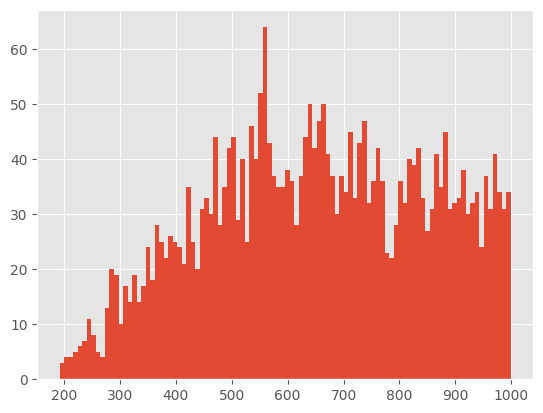

Max length: 855


In [160]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
lengths = [len(row['context'] + row['question']) for row in squad['train']]
plt.hist(lengths, bins=100)
plt.show()
target_max_length = int(np.percentile(lengths, 80))
print(f"Max length: {target_max_length}")

#### Justification for prompt

The prompts are collected from Flan 2022 Collection (Chung et al, arXiv:2210.11416).

Ref: https://arxiv.org/abs/2301.13688
Prompts are selected from this github https://github.com/google-research/FLAN/blob/main/flan/v2/flan_templates_branched.py



In [194]:
def preprocess_data(examples):
  """Adds prefix, tokenizes and sets the labels"""
  questions = examples["question"]
  contexts = examples["context"]
  titles = examples["title"]
  answers = []
  for answer in examples["answers.text"]:
    answers.append(answer[0])
  inputs = []
  for question, context in zip(questions, contexts):
    prefix = f"""Answer a question about this article:\n{context}\nQ:{question}A:"""
    input = prefix.format(context=context.strip(), question=question.strip())
    inputs.append(input)
  model_inputs = tokenizer(inputs,
                           truncation=True,
                           padding="max_length",
                           return_tensors='pt',
                           max_length=target_max_length)
  labels = tokenizer(text_target=answers, max_length=target_max_length, truncation=True)
  model_inputs["labels"] = labels["input_ids"]
  return model_inputs

tensored_data = squad.map(preprocess_data, remove_columns=squad["train"].column_names, batched=True)

Map:   0%|          | 0/3027 [00:00<?, ? examples/s]

Map:   0%|          | 0/749 [00:00<?, ? examples/s]

In [195]:
tensored_data

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 3027
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 749
    })
})

In [196]:
tokenizer.decode(tensored_data["train"][0]["input_ids"], skip_special_tokens=True)

'Answer a question about this article: The novel is renowned for its warmth and humor, despite dealing with the serious issues of rape and racial inequality. The narrator\'s father, Atticus Finch, has served as a moral hero for many readers and as a model of integrity for lawyers. One critic explains the novel\'s impact by writing, "In the twentieth century, To Kill a Mockingbird is probably the most widely read book dealing with race in America, and its protagonist, Atticus Finch, the most enduring fictional image of racial heroism." Q:Who is the protagonist of the novel?A:'

In [197]:
tokenizer.decode(tensored_data["train"][0]["labels"], skip_special_tokens=True)

'Atticus Finch'

In [198]:
tokenizer.decode(tensored_data["train"][500]["input_ids"], skip_special_tokens=True)

"Answer a question about this article: The official position of the Ministry of Foreign Affairs of the People's Republic of China is that the Ming implemented a policy of managing Tibet according to conventions and customs, granting titles and setting up administrative organs over Tibet. The State Council Information Office of the People's Republic states that the Ming dynasty's Ü-Tsang Commanding Office governed most areas of Tibet. It also states that while the Ming abolished the policy council set up by the Mongol Yuan to manage local affairs in Tibet and the Mongol system of Imperial Tutors to govern religious affairs, the Ming adopted a policy of bestowing titles upon religious leaders who had submitted to the Ming dynasty. For example, an edict of the Hongwu Emperor in 1373 appointed the Tibetan leader Choskunskyabs as the General of the Ngari Military and Civil Wanhu Office, stating: Q:Who governed most areas of Tibet?A:"

In [199]:
tokenizer.decode(tensored_data["train"][500]["labels"], skip_special_tokens=True)

"Ming dynasty's Ü-Tsang Commanding Office"

In [200]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model_name)

In [204]:
# Global Parameters
L_RATE = 5e-5
BATCH_SIZE = 8
PER_DEVICE_EVAL_BATCH = 8
WEIGHT_DECAY = 0.01
SAVE_TOTAL_LIM = 3
NUM_EPOCHS = 3

def compute_metrics(eval_preds):
   preds, labels = eval_preds
   # decode preds and labels
   labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
   decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
   decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
   # rougeLSum expects newline after each sentence
   decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
   decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]
   result = rogue_metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
   return result

# Set up training arguments
training_args = Seq2SeqTrainingArguments(
   output_dir="./results",
   evaluation_strategy="epoch",
   learning_rate=L_RATE,
   per_device_train_batch_size=BATCH_SIZE,
   per_device_eval_batch_size=PER_DEVICE_EVAL_BATCH,
   weight_decay=WEIGHT_DECAY,
   save_total_limit=SAVE_TOTAL_LIM,
   num_train_epochs=NUM_EPOCHS,
   predict_with_generate=True,
   push_to_hub=False
)

In [205]:
trainer = Seq2SeqTrainer(
   model=model,
   args=training_args,
   train_dataset=tensored_data["train"],
   eval_dataset=tensored_data["test"],
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics
)

In [206]:
# with 5k rows in data, training time on T4 -> 10 min
# Complete dataset, 10 epochs -> 1-2 hours
trainer.train()

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,No log,23.304234,0.006620,0.000000,0.006592,0.006585
2,28.312100,24.046284,0.008870,0.001869,0.008838,0.008901
3,26.961200,23.082314,0.010581,0.000000,0.010328,0.010369


TrainOutput(global_step=1137, training_loss=27.511879363181617, metrics={'train_runtime': 575.9612, 'train_samples_per_second': 15.767, 'train_steps_per_second': 1.974, 'total_flos': 1409473906836480.0, 'train_loss': 27.511879363181617, 'epoch': 3.0})

## Evaluate

In [207]:
trainer.evaluate()

{'eval_loss': 23.082313537597656,
 'eval_rouge1': 0.010580581708752602,
 'eval_rouge2': 0.0,
 'eval_rougeL': 0.010328489934631459,
 'eval_rougeLsum': 0.010369333233151657,
 'eval_runtime': 42.4463,
 'eval_samples_per_second': 17.646,
 'eval_steps_per_second': 2.215,
 'epoch': 3.0}

In [250]:
last_checkpoint = "./results/checkpoint-500"
finetuned_model = T5ForConditionalGeneration.from_pretrained(last_checkpoint)
tokenizer = T5Tokenizer.from_pretrained(last_checkpoint)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [259]:
my_question = "What do you think about the benefit of Artificial Intelligence?"
inputs = "Please answer to this question: " + my_question
inputs = tokenizer(inputs, return_tensors="pt")
outputs = finetuned_model.generate(**inputs)
print(outputs[0])
answer = tokenizer.decode(outputs[0], skip_special_tokens=False)
print(answer)

tensor([0, 3, 9, 1])
<pad> a</s>


In [262]:
for i in range(3):
  random_idx = random.randint(0, len(squad["train"]))
  question = squad["train"][random_idx]["question"]
  context = squad["train"][random_idx]["context"]
  title = squad["train"][random_idx]["title"]
  baseline_answer = squad["train"][random_idx]["answers.text"]
  prompt = f"""Please answer a question about the following article about {title}\n{context}\n\nQ: {question}"""
  print(prompt)
  print("====="*10)
  print("Baseline answer:")
  print(baseline_answer)
  print("====="*10)
  sentence_encoded = tokenizer(prompt, return_tensors='pt', max_length=256, truncation=True)
  pred_answer = finetuned_model.generate(sentence_encoded['input_ids'], max_new_tokens=100)
  sentence_decoded = tokenizer.decode(pred_answer[0], skip_special_tokens=True)
  print("Generated Answer")
  print(sentence_decoded)
  print("====="*10)
  rouge_score = rogue_metric.compute(predictions=[sentence_decoded], references=[baseline_answer])
  print(rouge_score)
  print("#####"*20)

Please answer a question about the following article about To_Kill_a_Mockingbird
One year after its publication To Kill a Mockingbird had been translated into ten languages. In the years since, it has sold more than 30 million copies and been translated into more than 40 languages. The novel has never been out of print in hardcover or paperback, and has become part of the standard literature curriculum. A 2008 survey of secondary books read by students between grades 9–12 in the U.S. indicates the novel is the most widely read book in these grades. A 1991 survey by the Book of the Month Club and the Library of Congress Center for the Book found that To Kill a Mockingbird was rated behind only the Bible in books that are "most often cited as making a difference".[note 1] It is considered by some to be the Great American Novel.

Q: After one year when To Kill a Mockingbird first came out, how many languages has it been printed in?
Baseline answer:
['ten']
Generated Answer
a
{'rouge1': 0.

## Appendix

## Apply PEFT

Parameter efficient fine tuning is an approach towards fine tuning large language models that fine tunes the model without altering all the model weights. You can learn more about it from my block post [here](https://www.linkedin.com/pulse/finetuning-large-language-models-using-novel-peft-srikanth-machiraju-owe2c%3FtrackingId=AVwu8o6uR%252F6J3n0BB6U7IA%253D%253D/?trackingId=AVwu8o6uR%2F6J3n0BB6U7IA%3D%3D)

In [263]:
%%bash
pip install -q peft

In [264]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
print(model)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=384, bias=False)
              (k): Linear(in_features=512, out_features=384, bias=False)
              (v): Linear(in_features=512, out_features=384, bias=False)
              (o): Linear(in_features=384, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 6)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=512, out_features=1024, bias=False)
              (wi_1): Linear(in_features=512, out_features=1024, bias=False)
              (wo): 

In [265]:
from peft import PeftModel, PeftConfig, LoraConfig, TaskType
from peft import get_peft_config, get_peft_model, get_peft_model_state_dict, LoraConfig, TaskType

lora_config = LoraConfig(
    r=16, #Rank
    lora_alpha=32,
    target_modules=["lm_head"], # we can use layer names from above to target more modules, here I'm only training linear layer
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_2_SEQ_LM # FLAN-T5
)

peft_model = get_peft_model(model, lora_config)
peft_model.print_trainable_parameters()

trainer = Seq2SeqTrainer(
   model=peft_model,
   args=training_args,
   train_dataset=tensored_data["train"],
   eval_dataset=tensored_data["test"],
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics
)

trainable params: 522,240 || all params: 77,483,392 || trainable%: 0.6740025010779084


In [266]:
trainer.train()

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,No log,0.305400,0.827916,0.523381,0.827761,0.827597
2,0.565700,0.303915,0.827446,0.522079,0.827243,0.827721
3,0.562300,0.303395,0.826331,0.520538,0.826208,0.826463


TrainOutput(global_step=1137, training_loss=0.558643129696003, metrics={'train_runtime': 396.8294, 'train_samples_per_second': 22.884, 'train_steps_per_second': 2.865, 'total_flos': 2843276640860160.0, 'train_loss': 0.558643129696003, 'epoch': 3.0})

In [269]:
for i in range(3):
  random_idx = random.randint(0, len(squad["train"]))
  question = squad["train"][random_idx]["question"]
  context = squad["train"][random_idx]["context"]
  title = squad["train"][random_idx]["title"]
  baseline_answer = squad["train"][random_idx]["answers.text"]
  prompt = f"""Please answer a question about the following article about {title}\n{context}\n\nQ: {question}"""
  print(prompt)
  print("====="*10)
  print("Baseline answer:")
  print(baseline_answer)
  print("====="*10)
  sentence_encoded = tokenizer(prompt, return_tensors='pt', max_length=256, truncation=True)
  pred_answer = peft_model.generate(input_ids=sentence_encoded['input_ids'])
  sentence_decoded = tokenizer.decode(pred_answer[0], skip_special_tokens=True)
  print("Generated Answer")
  print(sentence_decoded)
  print("====="*10)
  rouge_score = rogue_metric.compute(predictions=[sentence_decoded], references=[baseline_answer])
  print(rouge_score)
  print("#####"*20)

Please answer a question about the following article about New_York_City
New York City has over 28,000 acres (110 km2) of municipal parkland and 14 miles (23 km) of public beaches. Parks in New York City include Central Park, Prospect Park, Flushing Meadows–Corona Park, Forest Park, and Washington Square Park. The largest municipal park in the city is Pelham Bay Park with 2,700 acres (1,093 ha).

Q: What is the biggest public park in the city?
Baseline answer:
['Pelham Bay Park']


RuntimeError: ignored

## Fine tuning using Human feedback

[WIP]